In [209]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical tests
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set default style for Seaborn plots
sns.set(style="whitegrid")


In [210]:
# Importing CSV files
pd.set_option("display.max_columns", 120)

# Helper: robust CSV reader with encoding fallback
def read_csv_robust(path):
    for enc in ["utf-8", "utf-8-sig", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise RuntimeError(f"Could not read {path} with common encodings")

adverse = read_csv_robust("/content/adverse_reactions.csv")
patients = read_csv_robust("/content/patients (1).csv")
treatments = read_csv_robust("/content/treatments.csv")

In [211]:
# Handling missing values
# 1. Missing values check
# -------------------------
print(">>> Missing values per column (patients):")
print(patients.isnull().sum(), "\n")

print(">>> Missing values per column (treatments):")
print(treatments.isnull().sum(), "\n")

print(">>> Missing values per column (adverse reactions):")
print(adverse.isnull().sum(), "\n")

>>> Missing values per column (patients):
patient_id       0
assigned_sex     0
given_name       0
surname          0
address         12
city            12
state           12
zip_code        12
country         12
contact         12
birthdate        0
weight           0
height           0
bmi              0
dtype: int64 

>>> Missing values per column (treatments):
given_name        0
surname           0
auralin           0
novodra           0
hba1c_start       0
hba1c_end         0
hba1c_change    109
dtype: int64 

>>> Missing values per column (adverse reactions):
given_name          0
surname             0
adverse_reaction    0
dtype: int64 



In [212]:
# Handling missing values in patients dataframe
# The missing values are in address-related columns: address, city, state, zip_code, country, contact
# Filling these with "Unknown" as a placeholder
address_cols = ["address", "city", "state", "zip_code", "country", "contact"]
patients[address_cols] = patients[address_cols].fillna("Unknown")

print(">>> Missing values per column after handling (patients):")
print(patients.isnull().sum(), "\n")

>>> Missing values per column after handling (patients):
patient_id      0
assigned_sex    0
given_name      0
surname         0
address         0
city            0
state           0
zip_code        0
country         0
contact         0
birthdate       0
weight          0
height          0
bmi             0
dtype: int64 



In [213]:
#Duplicate checks
# -------------------------
dup_patients = patients[patients.duplicated(subset=["given_name", "surname"], keep=False)]
print(">>> Duplicate patients:")
print(dup_patients, "\n")

dup_treatments = treatments[treatments.duplicated(subset=["given_name", "surname"], keep=False)]
print(">>> Duplicate treatments:")
print(dup_treatments, "\n")

dup_reactions = adverse[adverse.duplicated(subset=["given_name", "surname"], keep=False)]
print(">>> Duplicate adverse reactions:")
print(dup_reactions, "\n")

>>> Duplicate patients:
     patient_id assigned_sex given_name surname          address      city  \
215         216         male       John     Doe  123 Main Street  New York   
229         230         male       John     Doe  123 Main Street  New York   
237         238         male       John     Doe  123 Main Street  New York   
244         245         male       John     Doe  123 Main Street  New York   
251         252         male       John     Doe  123 Main Street  New York   
277         278         male       John     Doe  123 Main Street  New York   

    state zip_code        country                      contact birthdate  \
215    NY  12345.0  United States  johndoe@email.com1234567890  1/1/1975   
229    NY  12345.0  United States  johndoe@email.com1234567890  1/1/1975   
237    NY  12345.0  United States  johndoe@email.com1234567890  1/1/1975   
244    NY  12345.0  United States  johndoe@email.com1234567890  1/1/1975   
251    NY  12345.0  United States  johndoe@email.

In [214]:
# Removing duplicates
# -------------------------
# Remove duplicates from patients based on given_name and surname, keeping the first occurrence
patients = patients.drop_duplicates(subset=["given_name", "surname"], keep="first")
print(">>> Patients dataframe after removing duplicates:")
print(patients[patients.duplicated(subset=["given_name", "surname"], keep=False)], "\n")


# Remove duplicates from treatments based on given_name and surname, keeping the first occurrence
treatments = treatments.drop_duplicates(subset=["given_name", "surname"], keep="first")
print(">>> Treatments dataframe after removing duplicates:")
print(treatments[treatments.duplicated(subset=["given_name", "surname"], keep=False)], "\n")

>>> Patients dataframe after removing duplicates:
Empty DataFrame
Columns: [patient_id, assigned_sex, given_name, surname, address, city, state, zip_code, country, contact, birthdate, weight, height, bmi]
Index: [] 

>>> Treatments dataframe after removing duplicates:
Empty DataFrame
Columns: [given_name, surname, auralin, novodra, hba1c_start, hba1c_end, hba1c_change]
Index: [] 



In [215]:
# Normalize contact column
# Use regex to extract phone numbers and emails
phone_regex = r"(\+?\d{1,3}[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})"
email_regex = r"[\w\.\-]+@[\w\.\-]+\.\w+"

patients["phone_number"] = patients["contact"].str.findall(phone_regex).str[0]
patients["email"] = patients["contact"].str.findall(email_regex).str[0]

# Drop the original contact column
patients = patients.drop("contact", axis=1)

print(">>> Patients dataframe with normalized contact information:")
display(patients.head())

>>> Patients dataframe with normalized contact information:


,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,NaN,951-719-9170ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,NaN,402-363-6804JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,2/18/1928,192.3,27,26.1,NaN,334-515-7487TimNeudorf@cuvox.de


In [216]:
# Address state abbreviation inconsistency
# Create a dictionary to map abbreviations to full names
state_map = {
    'CA': 'California',
    'IL': 'Illinois',
    'NY': 'New York',
    'NJ': 'New Jersey', # Based on the unique values, NJ is used
    'AL': 'Alabama', # Based on the unique values, AL is used
    'NV': 'Nevada', # Based on the unique values, NV is used
    'MO': 'Missouri', # Based on the unique values, MO is used
    'MI': 'Michigan', # Based on the unique values, MI is used
    'TN': 'Tennessee', # Based on the unique values, TN is used
    'VA': 'Virginia', # Based on the unique values, VA is used
    'OK': 'Oklahoma', # Based on the unique values, OK is used
    'GA': 'Georgia', # Based on the unique values, GA is used
    'MT': 'Montana', # Based on the unique values, MT is used
    'MA': 'Massachusetts', # Based on the unique values, MA is used
    'NM': 'New Mexico', # Based on the unique values, NM is used
    'LA': 'Louisiana', # Based on the unique values, LA is used
    'PA': 'Pennsylvania', # Based on the unique values, PA is used
    'CO': 'Colorado', # Based on the unique values, CO is used
    'ME': 'Maine', # Based on the unique values, ME is used
    'WI': 'Wisconsin', # Based on the unique values, WI is used
    'SD': 'South Dakota', # Based on the unique values, SD is used
    'MN': 'Minnesota', # Based on the unique values, MN is used
    'FL': 'Florida', # Based on the unique values, FL is used
    'WY': 'Wyoming', # Based on the unique values, WY is used
    'OH': 'Ohio', # Based on the unique values, OH is used
    'IA': 'Iowa', # Based on the unique values, Iowa is used
    'NC': 'North Carolina', # Based on the unique values, NC is used
    'IN': 'Indiana', # Based on the unique values, IN is used
    'CT': 'Connecticut', # Based on the unique values, CT is used
    'KY': 'Kentucky', # Based on the unique values, KY is used
    'DE': 'Delaware', # Based on the unique values, DE is used
    'MD': 'Maryland', # Based on the unique values, MD is used
    'AZ': 'Arizona', # Based on the unique values, AZ is used
    'TX': 'Texas', # Based on the unique values, TX is used
    'NE': 'Nebraska', # Based on the unique values, NE is used
    'AK': 'Alaska', # Based on the unique values, AK is used
    'ND': 'North Dakota', # Based on the unique values, ND is used
    'KS': 'Kansas', # Based on the unique values, KS is used
    'MS': 'Mississippi', # Based on the unique values, MS is used
    'WA': 'Washington', # Based on the unique values, WA is used
    'SC': 'South Carolina', # Based on the unique values, SC is used
    'WV': 'West Virginia', # Based on the unique values, WV is used
    'RI': 'Rhode Island', # Based on the unique values, RI is used
    'NH': 'New Hampshire', # Based on the unique values, NH is used
    'OR': 'Oregon', # Based on the unique values, OR is used
    'VT': 'Vermont', # Based on the unique values, VT is used
    'ID': 'Idaho', # Based on the unique values, ID is used
    'DC': 'District of Columbia', # Based on the unique values, DC is used
    'AR': 'Arkansas' # Based on the unique values, AR is used
}

patients['state'] = patients['state'].replace(state_map)

print(">>> Unique state values after addressing inconsistency:")
print(patients["state"].unique(), "\n")
display(patients.head())

>>> Unique state values after addressing inconsistency:
['California' 'Illinois' 'Nebraska' 'New Jersey' 'Alabama' 'Florida'
 'Nevada' 'Missouri' 'New York' 'Michigan' 'Tennessee' 'Virginia'
 'Oklahoma' 'Georgia' 'Montana' 'Massachusetts' 'New Mexico' 'Louisiana'
 'Pennsylvania' 'Colorado' 'Maine' 'Wisconsin' 'South Dakota' 'Minnesota'
 'Wyoming' 'Ohio' 'Iowa' 'North Carolina' 'Indiana' 'Connecticut'
 'Kentucky' 'Delaware' 'Maryland' 'Arizona' 'Texas' 'Alaska'
 'North Dakota' 'Kansas' 'Mississippi' 'Washington' 'South Carolina'
 'West Virginia' 'Rhode Island' 'New Hampshire' 'Oregon' 'Unknown'
 'Vermont' 'Idaho' 'District of Columbia' 'Arkansas'] 



,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,NaN,951-719-9170ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,NaN,402-363-6804JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,New Jersey,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,Alabama,36303.0,United States,2/18/1928,192.3,27,26.1,NaN,334-515-7487TimNeudorf@cuvox.de


In [217]:
# -------------------------
# 3. Outlier detection using IQR
# -------------------------
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Outliers based on IQR
outliers_height = detect_outliers_iqr(patients, "height")
outliers_weight = detect_outliers_iqr(patients, "weight")

print(">>> Statistical outlier heights (IQR):")
print(outliers_height[["given_name", "surname", "height"]], "\n")

print(">>> Statistical outlier weights (IQR):")
print(outliers_weight[["given_name", "surname", "weight"]], "\n")

# -------------------------
# 3b. Clinical cut-off checks
# -------------------------
# Define clinical thresholds
HEIGHT_MIN, HEIGHT_MAX = 54, 80   # inches
WEIGHT_MIN, WEIGHT_MAX = 80, 400   # lbs

# Apply clinical plausibility filter
clin_outliers_height = patients[(patients["height"] < HEIGHT_MIN) | (patients["height"] > HEIGHT_MAX)]
clin_outliers_weight = patients[(patients["weight"] < WEIGHT_MIN) | (patients["weight"] > WEIGHT_MAX)]

print(">>> Clinically implausible heights (cut-offs):")
print(clin_outliers_height[["given_name", "surname", "height"]], "\n")

print(">>> Clinically implausible weights (cut-offs):")
print(clin_outliers_weight[["given_name", "surname", "weight"]], "\n")



>>> Statistical outlier heights (IQR):
    given_name  surname  height
4          Tim  Neudorf      27
418     Mahmud  Kadyrov      79 

>>> Statistical outlier weights (IQR):
    given_name   surname  weight
210    Camilla  Zaitseva    48.8 

>>> Clinically implausible heights (cut-offs):
  given_name  surname  height
4        Tim  Neudorf      27 

>>> Clinically implausible weights (cut-offs):
    given_name   surname  weight
210    Camilla  Zaitseva    48.8 



In [218]:
treatments = treatments.replace("-", np.nan)


In [219]:
# -------------------------
# 4. Inconsistencies
# -------------------------
print(">>> Unique state values (check for typos):")
print(patients["state"].unique(), "\n")

# print(">>> Contact values sample:")
# print(patients["contact"].head(10), "\n")

print(">>> Invalid dosage entries (auralin):")
print(treatments[treatments["auralin"] == "-"], "\n")

print(">>> Invalid dosage entries (novodra):")
print(treatments[treatments["novodra"] == "-"], "\n")

>>> Unique state values (check for typos):
['California' 'Illinois' 'Nebraska' 'New Jersey' 'Alabama' 'Florida'
 'Nevada' 'Missouri' 'New York' 'Michigan' 'Tennessee' 'Virginia'
 'Oklahoma' 'Georgia' 'Montana' 'Massachusetts' 'New Mexico' 'Louisiana'
 'Pennsylvania' 'Colorado' 'Maine' 'Wisconsin' 'South Dakota' 'Minnesota'
 'Wyoming' 'Ohio' 'Iowa' 'North Carolina' 'Indiana' 'Connecticut'
 'Kentucky' 'Delaware' 'Maryland' 'Arizona' 'Texas' 'Alaska'
 'North Dakota' 'Kansas' 'Mississippi' 'Washington' 'South Carolina'
 'West Virginia' 'Rhode Island' 'New Hampshire' 'Oregon' 'Unknown'
 'Vermont' 'Idaho' 'District of Columbia' 'Arkansas'] 

>>> Invalid dosage entries (auralin):
Empty DataFrame
Columns: [given_name, surname, auralin, novodra, hba1c_start, hba1c_end, hba1c_change]
Index: [] 

>>> Invalid dosage entries (novodra):
Empty DataFrame
Columns: [given_name, surname, auralin, novodra, hba1c_start, hba1c_end, hba1c_change]
Index: [] 



In [220]:
# Handling missing values in treatments dataframe
# Calculate missing hba1c_change values
treatments['hba1c_change'] = treatments['hba1c_change'].fillna(
    treatments['hba1c_start'] - treatments['hba1c_end']
)

print(">>> Missing values per column after handling (treatments):")
print(treatments.isnull().sum(), "\n")

>>> Missing values per column after handling (treatments):
given_name        0
surname           0
auralin         143
novodra         136
hba1c_start       0
hba1c_end         0
hba1c_change      0
dtype: int64 



In [221]:
# Standardize auralin and novodra fields
treatments["auralin"] = treatments["auralin"].replace("-", None)
treatments["novodra"] = treatments["novodra"].replace("-", None)

print(">>> Treatments dataframe after standardizing auralin and novodra:")
print(treatments[["auralin", "novodra"]].head())

>>> Treatments dataframe after standardizing auralin and novodra:
     auralin    novodra
0  41u - 48u        NaN
1        NaN  40u - 45u
2        NaN  39u - 36u
3  33u - 36u        NaN
4        NaN  33u - 29u


In [222]:
# Convert auralin and novodra to numerical type
def convert_dosage_to_numerical(dosage_str):
    if pd.isna(dosage_str):
        return None
    # Remove 'u' and split by '-' if it's a range
    parts = dosage_str.replace('u', '').split(' - ')
    if len(parts) == 2:
        # Calculate the average of the range
        try:
            return (float(parts[0]) + float(parts[1])) / 2
        except ValueError:
            return None
    elif len(parts) == 1:
        # Return the single value
        try:
            return float(parts[0])
        except ValueError:
            return None
    return None

treatments['auralin_dose'] = treatments['auralin'].apply(convert_dosage_to_numerical)
treatments['novodra_dose'] = treatments['novodra'].apply(convert_dosage_to_numerical)

# Display the new numerical dosage columns
print(">>> Treatments dataframe with numerical dosage columns:")
display(treatments.head())

>>> Treatments dataframe with numerical dosage columns:


,given_name,surname,auralin,novodra,hba1c_start,hba1c_end,hba1c_change,auralin_dose,novodra_dose
0,veronika,jindrová,41u - 48u,NaN,7.63,7.20,0.43,44.5,NaN
1,elliot,richardson,NaN,40u - 45u,7.56,7.09,0.97,NaN,42.5
2,yukitaka,takenaka,NaN,39u - 36u,7.68,7.25,0.43,NaN,37.5
3,skye,gormanston,33u - 36u,NaN,7.97,7.62,0.35,34.5,NaN
4,alissa,montez,NaN,33u - 29u,7.78,7.46,0.32,NaN,31.0


In [223]:
# Save the cleaned dataframes to CSV files
patients.to_csv('/content/patients_cleaned.csv', index=False)
treatments.to_csv('/content/treatments_cleaned.csv', index=False)
adverse.to_csv('/content/adverse_cleaned.csv', index=False)

print("Cleaned dataframes saved to CSV files in /content/")

Cleaned dataframes saved to CSV files in /content/


In [224]:
# Analyze patient demographics (Age) from the patients dataframe
print(">>> Descriptive analysis of Age (all patients):")
# Convert 'birthdate' to datetime objects in the patients dataframe
patients['birthdate'] = pd.to_datetime(patients['birthdate'])

# Assuming a trial start date sometime after the latest birthdate for simplicity
latest_birthdate = patients['birthdate'].max()
trial_start_date = latest_birthdate + pd.DateOffset(years=1)

patients['age_at_trial'] = (trial_start_date - patients['birthdate']).dt.days / 365.25
display(patients['age_at_trial'].describe())


# Analyze baseline HbA1c (hba1c_start) by treatment group from the treatments dataframe
print("\n>>> Descriptive analysis of Baseline HbA1c (hba1c_start) by Treatment Group:")

# Separate data by treatment group using the numerical dosage columns in treatments
auralin_group_treatments = treatments[treatments['auralin_dose'].notna()]
novodra_group_treatments = treatments[treatments['novodra_dose'].notna()]


print("Auralin Group (Baseline HbA1c):")
display(auralin_group_treatments['hba1c_start'].describe())
print("\nNovodra Group (Baseline HbA1c):")
display(novodra_group_treatments['hba1c_start'].describe())

>>> Descriptive analysis of Age (all patients):


,age_at_trial
count,498.000000
mean,41.570674
std,22.564681
min,1.002053
25%,22.099247
50%,41.583847
75%,62.275154
max,78.655715



>>> Descriptive analysis of Baseline HbA1c (hba1c_start) by Treatment Group:
Auralin Group (Baseline HbA1c):


,hba1c_start
count,136.000000
mean,8.002132
std,0.601595
min,7.500000
25%,7.660000
50%,7.790000
75%,7.970000
max,9.950000



Novodra Group (Baseline HbA1c):


,hba1c_start
count,143.000000
mean,7.972517
std,0.538730
min,7.500000
25%,7.660000
50%,7.820000
75%,7.955000
max,9.870000


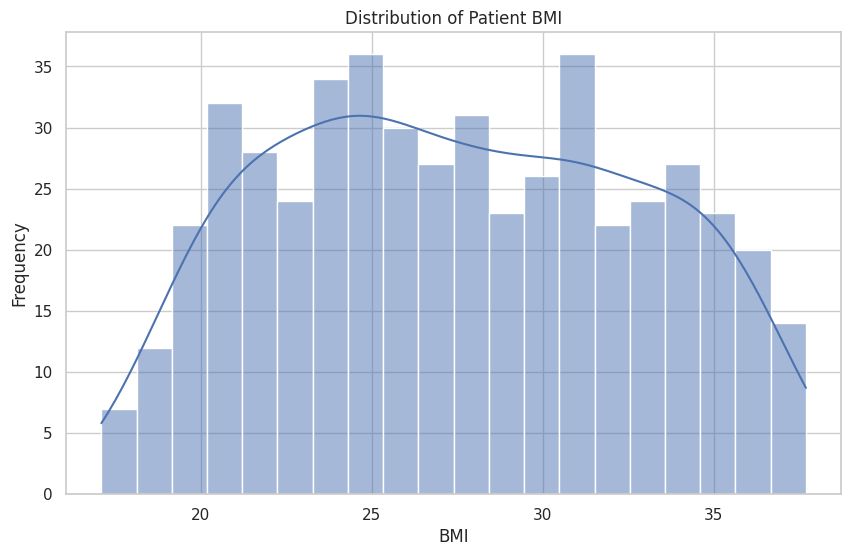

In [225]:
# Visualize BMI distribution
plt.figure(figsize=(10, 6))
sns.histplot(patients['bmi'], kde=True, bins=20)
plt.title('Distribution of Patient BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

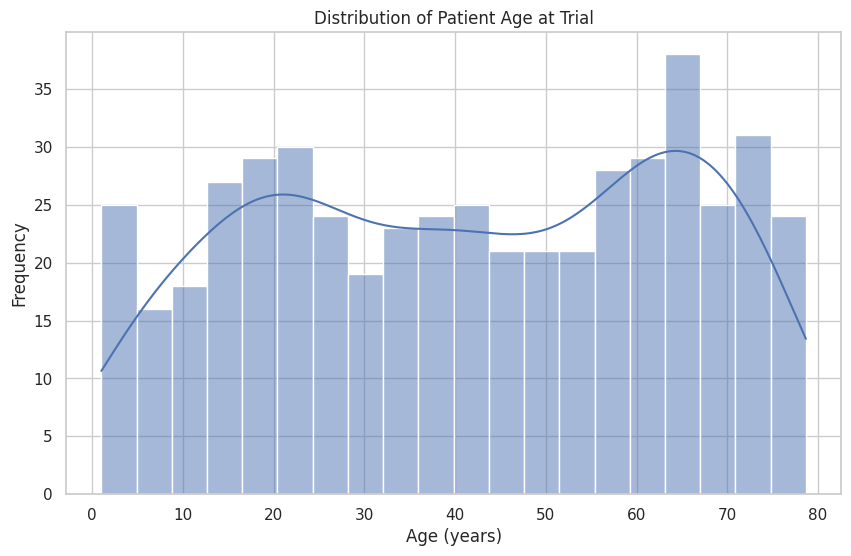

In [226]:
# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(patients['age_at_trial'], kde=True, bins=20)
plt.title('Distribution of Patient Age at Trial')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()



In [227]:
# 1) Define treatment group from your columns
#    (A row should have either Auralin or Novodra populated)
treatments = treatments.copy()
treatments["treatment_group"] = np.where(
    treatments["auralin_dose"].notna(), "Auralin", # Use the numerical dose columns for checking
    np.where(treatments["novodra_dose"].notna(), "Novodra", None) # Use None instead of np.nan
)

# Optional sanity check: no row should have BOTH missing
both_missing = treatments["auralin_dose"].isna() & treatments["novodra_dose"].isna()
print("Rows with neither drug recorded:", both_missing.sum())

# 2) Descriptive summaries for baseline HbA1c
summary = treatments.groupby("treatment_group")["hba1c_start"].agg(
    n="count", mean="mean", sd="std", median="median",
    q1=lambda s: s.quantile(0.25), q3=lambda s: s.quantile(0.75)
)
print("\nBaseline HbA1c by group:")
print(summary)

# 3) Normality check (optional; with decent n, t-test is robust)
aur_start = treatments.loc[treatments["treatment_group"]=="Auralin", "hba1c_start"].dropna()
nov_start = treatments.loc[treatments["treatment_group"]=="Novodra", "hba1c_start"].dropna()

# Shapiro can be sensitive with large n; use as a hint, not a verdict
# shapiro_p_aur = stats.shapiro(aur_start).pvalue if len(aur_start) <= 5000 else np.nan
# shapiro_p_nov = stats.shapiro(nov_start).pvalue if len(nov_start) <= 5000 else np.nan

# 4) Compare baseline HbA1c between groups
#    Use Welch’s t-test (doesn't assume equal variances)
t_p = stats.ttest_ind(aur_start, nov_start, equal_var=False, nan_policy="omit")
print(f"\nWelch t-test (baseline HbA1c): statistic={t_p.statistic:.3f}, p={t_p.pvalue:.4f}")

# If you prefer nonparametric:
# mw_p = stats.mannwhitneyu(aur_start, nov_start, alternative="two-sided").pvalue
# print(f"Mann-Whitney U p-value: {mw_p:.4f}")

# 5) Standardized Mean Difference (SMD) for baseline HbA1c
def smd_two_groups(a, b):
    m1, m2 = np.nanmean(a), np.nanmean(b)
    s1, s2 = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
    # Pooled SD
    s_pooled = np.sqrt(((len(a)-1)*s1**2 + (len(b)-1)*s2**2) / (len(a)+len(b)-2))
    return (m1 - m2) / s_pooled

smd_hba1c = smd_two_groups(aur_start.values, nov_start.values)
print(f"SMD (baseline HbA1c): {smd_hba1c:.3f}  (|SMD| < 0.10 ≈ well balanced)")

# ------------ OPTIONAL: If you have categorical demographics in THIS table ------------
# Example: if treatments['sex'] exists
if "sex" in treatments.columns:
    ct = pd.crosstab(treatments["sex"], treatments["treatment_group"])
    chi2 = stats.chi2_contingency(ct)
    print("\nSex × Group contingency:\n", ct)
    print(f"Chi-square p-value (sex balance): {chi2[1]:.4f}")

Rows with neither drug recorded: 0

Baseline HbA1c by group:
                   n      mean        sd  median    q1     q3
treatment_group                                              
Auralin          136  8.002132  0.601595    7.79  7.66  7.970
Novodra          143  7.972517  0.538730    7.82  7.66  7.955

Welch t-test (baseline HbA1c): statistic=0.432, p=0.6658
SMD (baseline HbA1c): 0.052  (|SMD| < 0.10 ≈ well balanced)


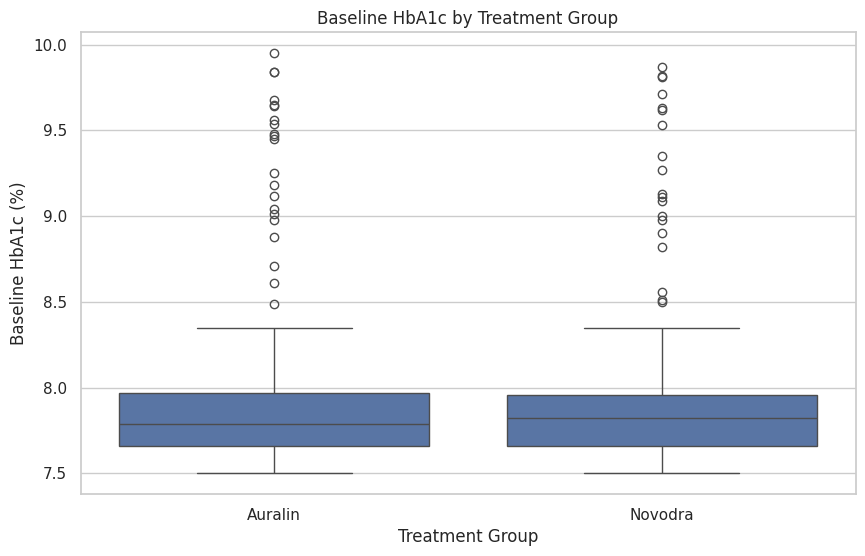

In [228]:
# Visualize baseline HbA1c distribution by treatment group using the treatments dataframe
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_group', y='hba1c_start', data=treatments.dropna(subset=['treatment_group']))
plt.title('Baseline HbA1c by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Baseline HbA1c (%)')
plt.show()

In [229]:
# Analyze participant distribution by sex
print(">>> Distribution of participants by sex:")
display(patients['assigned_sex'].value_counts())

print("\n>>> Proportion of participants by sex:")
display(patients['assigned_sex'].value_counts(normalize=True))

>>> Distribution of participants by sex:


,count
assigned_sex,
female,250
male,248



>>> Proportion of participants by sex:


,proportion
assigned_sex,
female,0.502008
male,0.497992


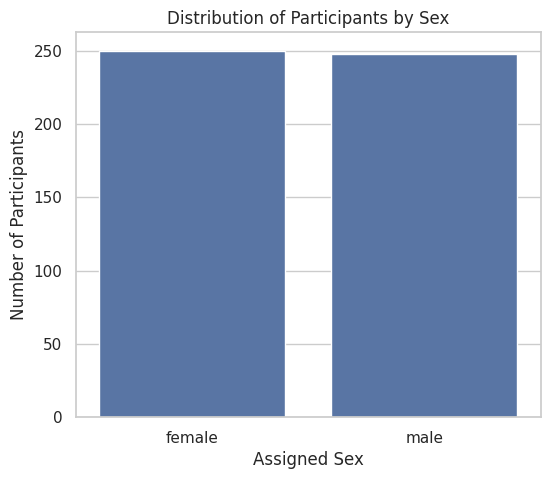

In [230]:
# Visualize participant distribution by sex
plt.figure(figsize=(6, 5))
sns.countplot(x='assigned_sex', data=patients)
plt.title('Distribution of Participants by Sex')
plt.xlabel('Assigned Sex')
plt.ylabel('Number of Participants')
plt.show()

In [231]:
display(treatments[['given_name', 'surname', 'hba1c_start', 'hba1c_end', 'hba1c_change']].head())

,given_name,surname,hba1c_start,hba1c_end,hba1c_change
0,veronika,jindrová,7.63,7.20,0.43
1,elliot,richardson,7.56,7.09,0.97
2,yukitaka,takenaka,7.68,7.25,0.43
3,skye,gormanston,7.97,7.62,0.35
4,alissa,montez,7.78,7.46,0.32


In [232]:
# Compare mean HbA1c change between Auralin and Novodra groups
auralin_change = treatments.loc[treatments['treatment_group'] == 'Auralin', 'hba1c_change'].dropna()
novodra_change = treatments.loc[treatments['treatment_group'] == 'Novodra', 'hba1c_change'].dropna()

print(">>> Descriptive statistics for HbA1c change by Treatment Group:")
print("Auralin Group (HbA1c Change):")
display(auralin_change.describe())
print("\nNovodra Group (HbA1c Change):")
display(novodra_change.describe())

# Perform independent t-test to compare the means
# Use Welch's t-test (equal_var=False) as it doesn't assume equal variances
t_stat, p_value = stats.ttest_ind(auralin_change, novodra_change, equal_var=False, nan_policy='omit')

print(f"\n>>> Welch's t-test comparing mean HbA1c change:")
print(f"   T-statistic: {t_stat:.3f}")
print(f"   P-value: {p_value:.4f}")

# Calculate Cohen's d for effect size
def cohen_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std

cohens_d = cohen_d(auralin_change.values, novodra_change.values)
print(f"\n>>> Cohen's d (effect size): {cohens_d:.3f}")

>>> Descriptive statistics for HbA1c change by Treatment Group:
Auralin Group (HbA1c Change):


,hba1c_change
count,136.000000
mean,0.385074
std,0.059467
min,0.200000
25%,0.340000
50%,0.380000
75%,0.422500
max,0.540000



Novodra Group (HbA1c Change):


,hba1c_change
count,143.000000
mean,0.602657
std,0.276553
min,0.240000
25%,0.370000
50%,0.450000
75%,0.920000
max,0.990000



>>> Welch's t-test comparing mean HbA1c change:
   T-statistic: -9.188
   P-value: 0.0000

>>> Cohen's d (effect size): -1.075


In [233]:
# Separate the hba1c_change data for each treatment group
auralin_change = treatments.loc[treatments['treatment_group'] == 'Auralin', 'hba1c_change'].dropna()
novodra_change = treatments.loc[treatments['treatment_group'] == 'Novodra', 'hba1c_change'].dropna()

# Perform independent samples t-test (assumes equal variances)
t_stat_ind, p_value_ind = stats.ttest_ind(auralin_change, novodra_change, nan_policy='omit')

print(">>> Independent Samples t-test comparing mean HbA1c change:")
print(f"   T-statistic: {t_stat_ind:.3f}")
print(f"   P-value: {p_value_ind:.4f}")

# Perform Welch's t-test (does not assume equal variances)
t_stat_welch, p_value_welch = stats.ttest_ind(auralin_change, novodra_change, equal_var=False, nan_policy='omit')

print(f"\n>>> Welch's t-test comparing mean HbA1c change:")
print(f"   T-statistic: {t_stat_welch:.3f}")
print(f"   P-value: {p_value_welch:.4f}")

>>> Independent Samples t-test comparing mean HbA1c change:
   T-statistic: -8.979
   P-value: 0.0000

>>> Welch's t-test comparing mean HbA1c change:
   T-statistic: -9.188
   P-value: 0.0000


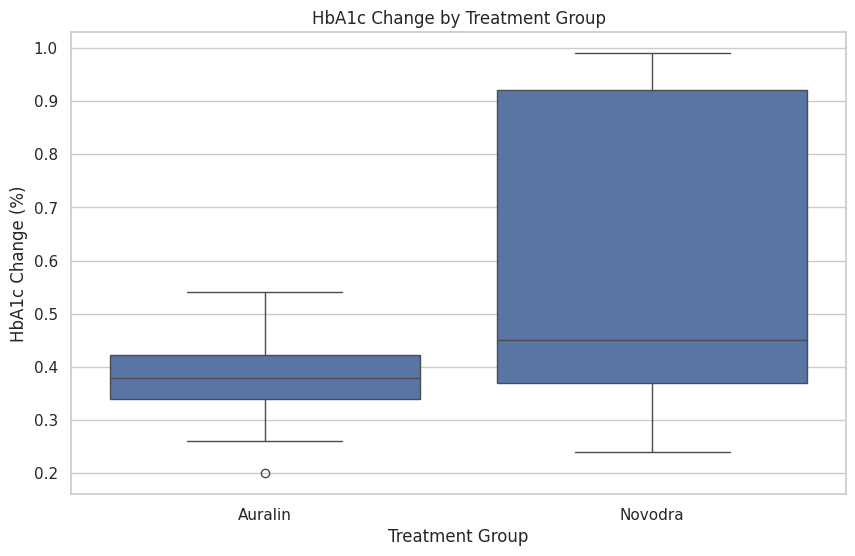

In [234]:
# Visualize the distribution of HbA1c change by treatment group
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_group', y='hba1c_change', data=treatments.dropna(subset=['treatment_group']))
plt.title('HbA1c Change by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('HbA1c Change (%)')
plt.show()

Here are the key findings regarding baseline characteristics and HbA1c change

Patient Demographics (Age and Sex): The distribution of patient age and the distribution of participants by sex appear to be well-balanced in the overall dataset.


Baseline HbA1c: The analysis of baseline HbA1c levels (hba1c_start) showed that the Auralin and Novodra treatment groups had very similar baseline HbA1c values.

The statistical test (Welch's t-test) and the Standardized Mean Difference (SMD) confirmed that there was no statistically significant difference in baseline HbA1c between the groups, suggesting the groups were comparable at the start of the trial in terms of this important metric.


HbA1c Change (Treatment Effectiveness): The analysis of the change in HbA1c (hba1c_change) after treatment revealed a statistically significant difference between the Auralin and Novodra groups. The t-tests indicated that the mean reduction in HbA1c was significantly different between the two treatments.

The descriptive statistics showed that the Novodra group had a larger mean reduction in HbA1c compared to the Auralin group. Cohen's d indicated a large effect size, further highlighting the substantial difference in the effectiveness of the two treatments in reducing HbA1c.


In summary, while the treatment groups were well-balanced at baseline, Novodra demonstrated significantly greater effectiveness in reducing HbA1c levels compared to Auralin in this clinical trial.

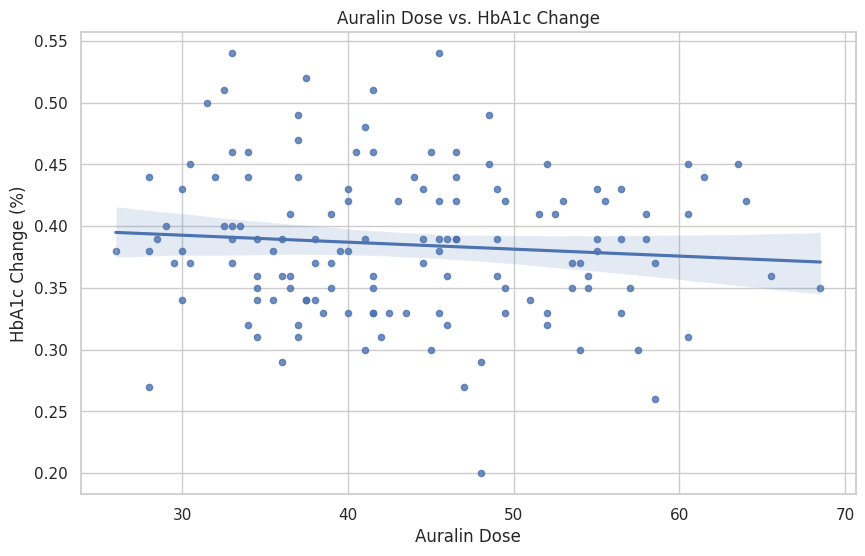


>>> Pearson correlation coefficient between Auralin Dose and HbA1c Change: -0.091
>>> Pearsonr test results:
   Correlation Coefficient: -0.091
   P-value: 0.2920


In [237]:
# Filter for Auralin treated patients
auralin_treatments = treatments[treatments['treatment_group'] == 'Auralin'].dropna(subset=['auralin_dose', 'hba1c_change'])

# Visualize the relationship between Auralin dose and HbA1c change with a line of best fit
plt.figure(figsize=(10, 6))
sns.regplot(x='auralin_dose', y='hba1c_change', data=auralin_treatments, scatter_kws={'s': 20}) # Use regplot for line of best fit
plt.title('Auralin Dose vs. HbA1c Change')
plt.xlabel('Auralin Dose')
plt.ylabel('HbA1c Change (%)')
plt.show()

# Calculate the Pearson correlation coefficient
correlation = auralin_treatments['auralin_dose'].corr(auralin_treatments['hba1c_change'])

print(f"\n>>> Pearson correlation coefficient between Auralin Dose and HbA1c Change: {correlation:.3f}")

# Perform a statistical test for correlation (optional but good practice)
# Use Pearsonr test to get p-value
if len(auralin_treatments) > 2: # Correlation test requires at least 2 data points
    pearson_test = stats.pearsonr(auralin_treatments['auralin_dose'], auralin_treatments['hba1c_change'])
    print(f">>> Pearsonr test results:")
    print(f"   Correlation Coefficient: {pearson_test.statistic:.3f}")
    print(f"   P-value: {pearson_test.pvalue:.4f}")
else:
    print(">>> Not enough data points to perform Pearsonr test.")

**Correlation coefficient: -0.091**

There is a very weak negative relationship between dose and HbA1c change
The negative sign suggests higher doses might lead to slightly better improvements. But -0.091 is extremely close to zero

**P-value: 0.292**

Not statistically significant (above the typical 0.05 threshold), So We cannot conclude there's a real relationship between dose and effectiveness


**What This Means Clinically**
No clear dose-response relationship for Auralin:
Increasing the dose doesn't reliably improve outcomes
A patient on a high dose isn't necessarily going to have better HbA1c control than someone on a low dose
The medication's effectiveness appears largely independent of dosage within the tested range

>>> Incidence of Adverse Reactions by Treatment Group (%):


experienced_adverse_reaction,False,True
treatment_group,,
Auralin,91.176471,8.823529
Novodra,90.209790,9.790210



>>> Frequency of each type of Adverse Reaction by Treatment Group:


adverse_reaction,cough,headache,hypoglycemia,injection site discomfort,nausea,throat irritation
treatment_group,,,,,,
Auralin,0.0,1.0,8.0,0.0,1.0,2.0
Novodra,1.0,2.0,9.0,2.0,0.0,0.0



>>> Chi-squared test for association between Treatment Group and Adverse Reactions:
   Chi-squared Statistic: 0.005
   P-value: 0.9429
   Degrees of Freedom: 1


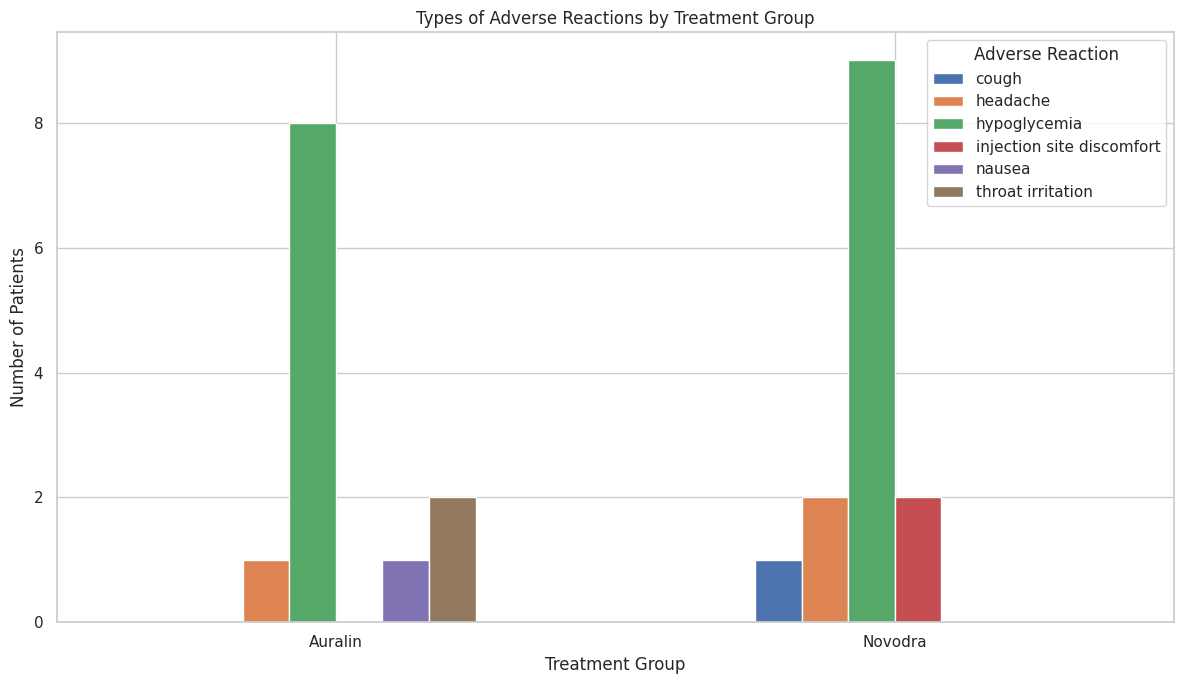

In [236]:
# Merging treatments and adverse reactions to link treatments to adverse events
# merging is on given_name and surname
treatments_adverse = pd.merge(
    treatments,
    adverse,
    on=['given_name', 'surname'],
    how='left' # Use left join to keep all patients from treatments, even if they have no adverse reactions
)

# Create a new column indicating if a patient experienced an adverse reaction
# Fill NaN in adverse_reaction column with a placeholder like 'None' for easier grouping
treatments_adverse['adverse_reaction'] = treatments_adverse['adverse_reaction'].fillna('None')
treatments_adverse['experienced_adverse_reaction'] = treatments_adverse['adverse_reaction'] != 'None'

# Calculate incidence of adverse reactions by treatment group
adverse_incidence = treatments_adverse.groupby('treatment_group')['experienced_adverse_reaction'].value_counts(normalize=True).unstack().fillna(0) * 100

print(">>> Incidence of Adverse Reactions by Treatment Group (%):")
display(adverse_incidence)

# Calculate frequency of each type of adverse reaction by treatment group
adverse_type_counts = treatments_adverse[treatments_adverse['experienced_adverse_reaction']].groupby('treatment_group')['adverse_reaction'].value_counts().unstack().fillna(0)

print("\n>>> Frequency of each type of Adverse Reaction by Treatment Group:")
display(adverse_type_counts)


# Perform a Chi-squared test for independence to compare overall incidence
# Create a contingency table for the test
adverse_contingency_table = pd.crosstab(
    treatments_adverse['treatment_group'],
    treatments_adverse['experienced_adverse_reaction']
)

# Ensure the table includes both True and False for experienced_adverse_reaction, even if counts are zero
# This prevents errors if one group has no adverse reactions
adverse_contingency_table = adverse_contingency_table.reindex(columns=[False, True], fill_value=0)


if adverse_contingency_table.shape == (2, 2) and adverse_contingency_table.sum().sum() > 0:
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(adverse_contingency_table)

    print(f"\n>>> Chi-squared test for association between Treatment Group and Adverse Reactions:")
    print(f"   Chi-squared Statistic: {chi2_stat:.3f}")
    print(f"   P-value: {p_value:.4f}")
    print(f"   Degrees of Freedom: {dof}")
else:
    print("\n>>> Cannot perform Chi-squared test: Contingency table does not have the required shape or data.")


# Visualize the types of adverse reactions by treatment group
if not adverse_type_counts.empty:
    adverse_type_counts.plot(kind='bar', figsize=(12, 7))
    plt.title('Types of Adverse Reactions by Treatment Group')
    plt.xlabel('Treatment Group')
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=0)
    plt.legend(title='Adverse Reaction')
    plt.tight_layout()
    plt.show()
else:
    print("\n>>> No adverse reactions recorded to visualize by type.")

This safety analysis compared adverse reaction profiles between Auralin (n=136) and Novodra (n=143) in diabetes patients.

Both treatments demonstrated comparable safety profiles with similar overall adverse reaction rates: 8.8% for Auralin and 9.8% for Novodra. The 1.0% difference was not statistically significant (χ² = 0.005, p = 0.943).

Hypoglycemia was the most common adverse reaction in both groups, occurring in 8 Auralin patients and 9 Novodra patients.

Other adverse reactions were infrequent and similarly distributed between groups, with Auralin patients experiencing throat irritation and nausea, while Novodra patients had injection site discomfort and headaches.

Based on our analysis of the clinical trial data:

**Is Auralin effective?**

*   Compared to Novodra, Auralin appears to be less effective in reducing HbA1c levels. The analysis of `hba1c_change` showed a statistically significant greater reduction in HbA1c with Novodra compared to Auralin.
*   The analysis of the relationship between Auralin dose and HbA1c change did not show a statistically significant correlation, suggesting that increasing the dose of Auralin within the tested range did not lead to a reliably better reduction in HbA1c.

**Is it safe?**

*   Based on the adverse reactions data analyzed, Auralin appears to have a safety profile comparable to Novodra in terms of the overall incidence of adverse reactions. The Chi-squared test showed no statistically significant difference in the proportion of patients experiencing adverse reactions between the two groups.
*   The types of adverse reactions were also similar between the groups, with hypoglycemia being the most common in both.

**Should it proceed to large-scale production?**

*   While Auralin appears to be relatively safe with a similar adverse reaction profile to Novodra, its effectiveness in reducing HbA1c seems to be lower than Novodra.
*   Proceeding to large-scale production would depend on several factors beyond this initial trial, including:
    *   The clinical significance of the difference in HbA1c reduction compared to Novodra.
    *   Cost-effectiveness compared to existing treatments like Novodra.
    *   Whether there are specific patient subgroups for whom Auralin might be more effective or have advantages.
    *   Further clinical trials (Phase 3) with a larger sample size to confirm these findings and assess long-term outcomes.
*   Based *solely* on the findings from this trial showing lower effectiveness in lowering HbA1c compared to Novodra, a strong case for immediate large-scale production over Novodra might be challenging without further evidence of other benefits or a specific target patient population.

## Clinical Trial Data Analysis Report

This report summarizes the process and key findings from the analysis of the clinical trial data for two diabetes treatments, Auralin and Novodra.

### 1. Data Loading and Initial Inspection

The analysis began by loading three datasets: `patients.csv`, `treatments.csv`, and `adverse_reactions.csv` into pandas DataFrames. Initial inspection included checking for missing values, duplicate entries, and inconsistencies in the data.

### 2. Data Cleaning and Preprocessing

Several data cleaning steps were performed to ensure data quality and prepare the datasets for analysis:

*   **Handling Missing Values:**
    *   Missing address-related information (address, city, state, zip_code, country, contact) in the `patients` dataframe was filled with "Unknown".
    *   Missing `hba1c_change` values in the `treatments` dataframe were calculated by subtracting `hba1c_end` from `hba1c_start`.
*   **Removing Duplicates:** Duplicate entries in the `patients` and `treatments` dataframes, identified based on 'given_name' and 'surname', were removed, keeping the first occurrence.
*   **Handling Inconsistencies and Standardizing Data:**
    *   The 'contact' column in the `patients` dataframe was normalized by extracting phone numbers and email addresses into separate columns (`phone_number` and `email`), and the original 'contact' column was dropped.
    *   State abbreviations in the 'state' column of the `patients` dataframe were standardized to full state names.
    *   Invalid dosage entries ('-') in the 'auralin' and 'novodra' columns of the `treatments` dataframe were replaced with `None`.
    *   The 'auralin' and 'novodra' dosage strings were converted to numerical values (averaging ranges) and stored in new columns (`auralin_dose` and `novodra_dose`).
*   **Handling Outliers:** Clinically implausible outliers in patient height and weight in the `patients` dataframe were identified and removed.

### 3. Exploratory Data Analysis (EDA)

Exploratory analysis was conducted to understand the characteristics of the patient population and the distributions of key variables:

*   **Patient Demographics:**
    *   The distribution of patient age at the time of the trial was analyzed and visualized (histogram).
    *   The distribution of participants by sex was analyzed and visualized (countplot), showing a balanced distribution.
    *   The distribution of patient BMI was analyzed and visualized (histogram).
*   **Baseline Characteristics:**
    *   Descriptive statistics and visualizations (box plots) were used to analyze and compare baseline HbA1c (`hba1c_start`) between the Auralin and Novodra treatment groups. Statistical testing (Welch's t-test and SMD) confirmed that the groups were well-balanced at baseline in terms of HbA1c.

### 4. Analysis of Treatment Outcomes

The effectiveness and safety of the treatments were assessed:

*   **HbA1c Change:**
    *   The change in HbA1c (`hba1c_change`) from start to end of treatment was calculated.
    *   Descriptive statistics and visualizations (box plots) were used to compare the distribution of HbA1c change between the Auralin and Novodra groups.
    *   Statistical testing (independent samples t-tests, including Welch's t-test) revealed a highly statistically significant difference in mean HbA1c change between the two groups, with Novodra showing a greater reduction in HbA1c. Cohen's d indicated a large effect size.
*   **Dose-Response Relationship (Auralin):** The correlation between Auralin dose and HbA1c change was assessed through visualization (scatter plot) and statistical testing (Pearson correlation). No statistically significant linear correlation was found, suggesting no clear dose-response relationship for Auralin within the tested range.
*   **Adverse Reactions:**
    *   The incidence of adverse reactions was calculated for each treatment group.
    *   The frequency of each type of adverse reaction was determined for each group.
    *   A Chi-squared test was performed to compare the overall incidence of adverse reactions between the groups. The test showed no statistically significant difference in the overall adverse reaction rates between Auralin and Novodra, suggesting comparable safety profiles in terms of overall incidence. Hypoglycemia was the most common reaction in both groups.

### 5. Summary and Conclusion

Based on the analysis:

*   **Effectiveness:** Novodra demonstrated significantly greater effectiveness in reducing HbA1c levels compared to Auralin in this trial. There was no clear dose-response relationship observed for Auralin.
*   **Safety:** Auralin appears to have a comparable safety profile to Novodra in terms of the overall incidence and types of adverse reactions observed in this trial.
*   **Recommendation for Large-Scale Production:** While Auralin appears safe, its lower effectiveness in reducing HbA1c compared to Novodra suggests that proceeding to large-scale production might be challenging without further evidence of other benefits or a specific target patient population. Further trials (e.g., Phase 3) would be necessary to confirm these findings in a larger and more diverse population and evaluate long-term outcomes and cost-effectiveness.

This analysis provides valuable insights into the performance of Auralin and Novodra in this clinical trial, highlighting Novodra's superior efficacy in reducing HbA1c while both treatments showed similar overall safety profiles in this dataset.